# Fast Wavelet Transform

Adapted from Gabriel Peyré's http://www.numerical-tours.com/

This notebook aims to familiarize you with the Fast Wavelet Transform algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Introduction

The Wavelet transform of a continuous function $f(x)$ computes the set of inner products 
$$ d_j[n] = \langle f, \psi_{j,n}\rangle $$ 
for scales $ j \in \mathbb Z $, position $ n \in \mathbb Z$.


The wavelet atoms are defined by scaling and translating the mother
atom $ \psi$:
$$ \psi_{j,n}(x) = \frac{1}{2^j}\psi \left( \frac{x-2^j n}{2^j} \right)  $$


The fast wavelet transform algorithm does not make use of the wavelet and scaling function,
but of the filters $h$ and $g$ that caracterize their interaction:
$$ g[n] = \frac{1}{\sqrt{2}}\langle \psi(t/2), \phi(t-n)\rangle 
\text{ and } h[n] = \frac{1}{\sqrt{2}}\langle \phi(t/2), \phi(t-n)\rangle. $$


The simplest filters are the Haar filters
$$ h = [1, 1]/\sqrt{2} \text{ and } g = [-1, 1]/\sqrt{2}. $$

## Generating a 1-D signal

Let us first generate a 1-D signal of resolution $N=2^8$.

In [2]:
n = 2**8  # 256

In [3]:
# Generating a random-looking signal, with some regularity.
xx = np.linspace(0, 1, 64)
f = np.concatenate(
    (
        np.sin(np.pi * xx / 2),
        1 - (xx - 0.5) ** 2,
        1 - xx**2,
        1 - np.sin(np.pi * xx / 2),
    )
)


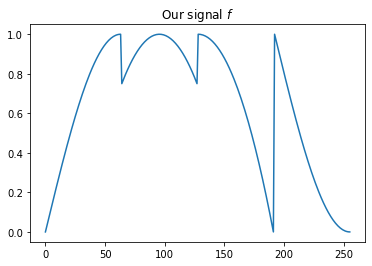

In [4]:
plt.title("Our signal $f$")
plt.plot(f)
plt.show()

## Implementing the FWT

Now, let us define the low-pass filter for Haar wavelets. Note that the filter should have odd length, so we zero-padd it.

In [5]:
# Haar wavelet.
h = [0, 1, 1]
h = h / np.linalg.norm(h)

Note that the high pass filter $g$ is computed directly from the low pass filter as $ g[n] = (-1)^{1-n}h[1-n].$

___________

**Question 1:** Use the formula above to compute $g$. Verify that $ h = [0, 1, 1]/\sqrt{2} \text{ and } g = [0, -1, 1]/\sqrt{2}. $

In [6]:
u = np.power(-np.ones(len(h) - 1), range(1, len(h)))  # alternate +1/-1
g = np.concatenate(([0], h[-1:0:-1] * u))

print("h:", h)
print("g:", g)

h: [0.         0.70710678 0.70710678]
g: [ 0.         -0.70710678  0.70710678]


____________

The basic wavelet operation is low/high filtering, followed by down sampling. 

Starting from some 1-D signal $a_{-J} = f \in \mathbb R^N$ where $N = 2^J$, one thus computes the
low pass signal $a_{-J+1} \in \mathbb R^{N/2}$ and the high pass 
signal $d_{-J+1} \in \mathbb R^{N/2}$ as
$$ a_{-J+1} = (f \star \tilde h) \downarrow 2 \text{ and } 
d_{-J+1} = (f \star \tilde g) \downarrow 2$$
where the sub-sampling is defined as 
$$ (u \downarrow 2)[k] = u[2k]. $$
and the reverse function (computed modulo $N$) as
$$\tilde h[n]=h[-n]$$

Let's define a circular convolution function.

In [7]:
from scipy.ndimage import convolve

cconv = lambda x, y: convolve(x, y, mode="wrap")

We can initialize $a_{-J} = f$, and create dictionaries to store the next $a$ and $d$.

In [8]:
a, d = {}, {}
a[-8] = f

____________

**Question 2**: Implement simple subsampling and reverse functions. Then, compute `a[-7]` and `d[-7]` using the formula above, and display them.

In [9]:
subsampling = lambda x: x[::2]

def reverse(x):
    return x[::-1]

In [10]:
a[-7] = subsampling(cconv(a[-8], reverse(h)))
d[-7] = subsampling(cconv(a[-8], reverse(g)))

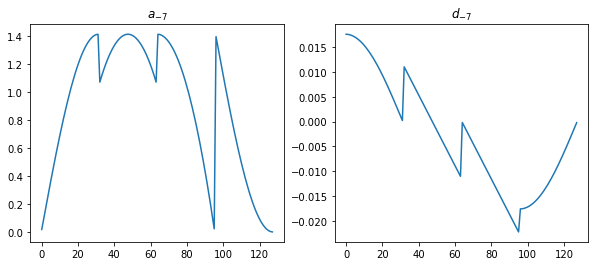

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(a[-7])
axes[0].set_title("$a_{-7}$")
axes[1].plot(d[-7])
axes[1].set_title("$d_{-7}$")
plt.show()

______

**Question 3:** Loop through the FWT algorithm until $a_{-5}$, and store the details $d_{-7}, d_{-6}, d_{-5}$.

In [12]:
for i in list(range(5, 8)[::-1]):
    a[-i] = subsampling(cconv(a[-(i + 1)], reverse(h)))
    d[-i] = subsampling(cconv(a[-(i + 1)], reverse(g)))

Make a pretty display of the coarse signal and the details.

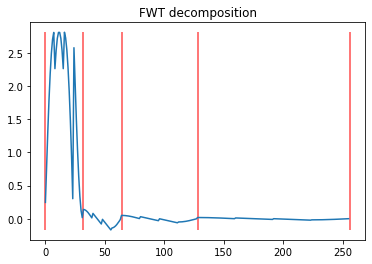

In [13]:
concat = []
vlines = [0]
for signal in [a[-5], d[-5], d[-6], d[-7]]:
    concat = np.concatenate((concat, signal))
    vlines.append(vlines[-1] + len(signal))

plt.title("FWT decomposition")
plt.plot(concat)
plt.vlines(vlines, ymin=concat.min(), ymax=concat.max(), color="r", alpha=0.7)
plt.show()

## Inverse FWT

For orthogonal filters, the reverse of this process is its dual
(aka its transpose), which is upsampling followed by low/high pass
filtering with the reversed filters and summing:
$$ (a \uparrow 2) \star h + (d \uparrow 2) \star g = f $$
where $ (u \uparrow 2)[2n]=u[n] $ and  $ (u \uparrow 2)[2n+1]=0 $.

**Question 4:** Implement a simple upsampling function, then reconstruct $a_{-6}$ from $a_{-5}$ and $d_{-5}$. Display the reconstruction.

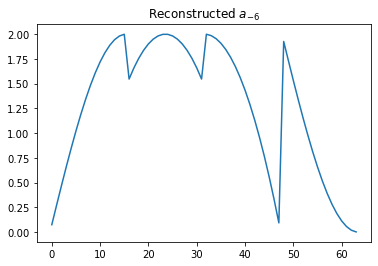

In [14]:
def upsampling(x):
    y = np.zeros(len(x) * 2)
    y[::2] = x
    return y


a_rec = cconv(upsampling(a[-5]), h) + cconv(upsampling(d[-5]), g)

plt.title("Reconstructed $a_{-6}$")
plt.plot(a_rec)
plt.show()

______________

**Question 5:** Now, loop through the inverse FWT to reconstruct $a_{-8}$, i.e. the original signal. Display the result and check numerically that we really recover the same signal.

In [15]:
a_rec = cconv(upsampling(a[-5]), h) + cconv(upsampling(d[-5]), g)
a_rec = cconv(upsampling(a_rec), h) + cconv(upsampling(d[-6]), g)
a_rec = cconv(upsampling(a_rec), h) + cconv(upsampling(d[-7]), g)

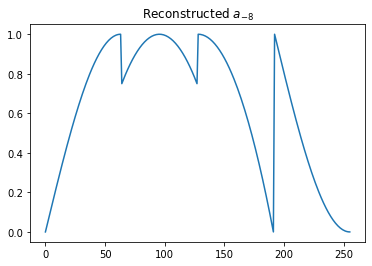

In [16]:
plt.title("Reconstructed $a_{-8}$")
plt.plot(a_rec)
plt.show()

In [17]:
print(np.linalg.norm(f - a_rec) / np.linalg.norm(f))

5.46716273017769e-16


## Daubechies wavelets

Daubechies wavelets extends the haar wavelets by using longer
filters, that produce smoother scaling functions and wavelets.
Furthermore, the larger the size $p=2k$ of the filter, the higher is the number
$k$ of vanishing moment. 

A high number of vanishing moments allows to better compress regular
parts of the signal. However, increasing the number of vanishing moments
also inceases the size of the support of the wavelets, wich can be
problematic in part where the signal is singular (for instance
discontinuous).

Choosing the _best_ wavelet, and thus choosing $k$, that is adapted to a
given class of signals, thus corresponds to 
a tradeoff between efficiency in regular and singular parts.

- The filter with $k=1$ vanishing moments corresponds to the Haar filter.
- The filter with $k=2$ vanishing moments corresponds to the famous |D4| wavelet, which compresses perfectly linear signals.
- The filter with $k=3$ vanishing moments compresses perfectly quadratic signals.

In [18]:
# Daubechies 4 wavelet.
h = [0, 1 + np.sqrt(3), 3 + np.sqrt(3), 3 - np.sqrt(3), 1 - np.sqrt(3)]
h = h / np.linalg.norm(h)

____________

**Question 6:** Repeat all of the above for the Daubechies wavelet, and verify that the inverse FWT recovers the original signal.

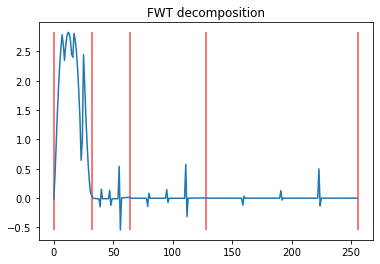

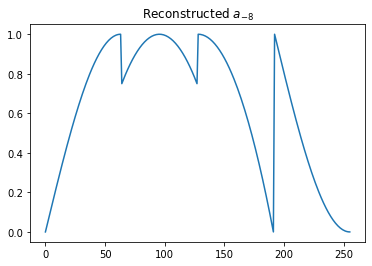

Reconstruction error: 2.0855085202861535e-16


In [19]:
u = np.power(-np.ones(len(h) - 1), range(1, len(h)))  # alternate +1/-1
g = np.concatenate(([0], h[-1:0:-1] * u))

a, d = {}, {}
a[-8] = f

for i in list(range(5, 8)[::-1]):
    a[-i] = subsampling(cconv(a[-(i + 1)], reverse(h)))
    d[-i] = subsampling(cconv(a[-(i + 1)], reverse(g)))

concat = []
vlines = [0]
for signal in [a[-5], d[-5], d[-6], d[-7]]:
    concat = np.concatenate((concat, signal))
    vlines.append(vlines[-1] + len(signal))

plt.title("FWT decomposition")
plt.plot(concat)
plt.vlines(vlines, ymin=concat.min(), ymax=concat.max(), color="r", alpha=0.7)
plt.show()

a_rec = cconv(upsampling(a[-5]), h) + cconv(upsampling(d[-5]), g)
a_rec = cconv(upsampling(a_rec), h) + cconv(upsampling(d[-6]), g)
a_rec = cconv(upsampling(a_rec), h) + cconv(upsampling(d[-7]), g)

plt.title("Reconstructed $a_{-8}$")
plt.plot(a_rec)
plt.show()

print("Reconstruction error:", np.linalg.norm(f - a_rec) / np.linalg.norm(f))